In [14]:
import matplotlib.pyplot as plt
import time
import torch
from torch import logsumexp
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import numpy as np

In [48]:
iterations = 100
p_mu = 0.0

lr = 1e-3
adam_b1 = 0.9
adam_b2 = 0.999

log_Z = np.log(np.sqrt((2*np.pi)))

In [49]:
def smooth_exponential(values, beta=0.9):
    v = np.asarray(values)
    t = np.arange(len(values))
    dt = t[None, :] - t[:,None] 
    w = np.exp((1-beta) * dt + np.log(t[None,:] <= t[:, None]))
    w /= w.sum(1)[:, None]
    v_smooth = np.dot(w, v[:, None])
    return v_smooth

In [50]:
# T = 1001
# t = np.arange(T)
# x = t/T
# y = 1 - x + 0.5 * np.random.randn(T)
# y_avg = smooth_exponential(y, 0.9)
# y2_avg = smooth_exponential(y, 0.999)
# y_adam = smooth_exponential(y, 0.9) / y2_avg**0.5
# plt.figure()
# plt.plot(t, y, label='noisy')
# plt.plot(t, y_adam, label='adam')
# plt.legend()

In [51]:
def rws(num_samples, q_mu, q_sigma, lr):
    EUBO = []
    ELBO = []
    Grad = []
    for i in range(iterations):
        proposal = Normal(q_mu, q_sigma)
        xs = proposal.sample((num_samples,))
        log_gammas = (-1.0 / 2.0) * ((xs - p_mu) ** 2)
        log_q = proposal.log_prob(xs)

        log_weights = log_gammas - log_q
        weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
        eubo = torch.mul(weights, log_weights).sum()
        elbo = log_weights.mean()
        gradient = torch.autograd.grad(eubo, q_mu)
        q_mu = q_mu - lr * gradient[0]
        EUBO.append(eubo.item())
        ELBO.append(elbo.item())
        Grad.append(gradient[0].item())
        AdamGrad = smooth_exponential(Grads, adam_b1) / smooth_exponential(Grads, adam_b2) 
    return EUBO, ELBO, Grad, AdamGrad

In [52]:
def plot_results(EUBOs, ELBOs, Grads, AdamGrads, num_sigmas, num_samples, mu, init_sigmas, SAMPLES):
    fig = plt.figure(figsize=(20, 20))
    for j in range(num_sigmas):
        for k in range(num_samples):
            ax = fig.add_subplot(num_sigmas, num_samples, j*num_samples + k + 1)
            ax.plot(EUBOs[j*num_samples + k], 'r', label='EUBOs')
            ax.plot(ELBOs[j*num_samples + k], 'b', label='ELBOs')
            ax.plot(Grads[j*num_samples + k], 'g', label='estimated grad')

            ax.plot(AdamGrads[j*num_samples + k], 'orange', label='adam grad')
            ax.plot(np.ones(iterations) * log_Z, 'k', label='log_Z')
            ax.tick_params(labelsize=18)
            ax.set_ylim([-50, 20])
            ax.set_title('mu=%d, sigma=%d, samples=%d' % (mu, init_sigmas[j], SAMPLES[k]), fontsize=18)
            if j == 0 and k == 0:
                ax.legend()

    plt.savefig('univariate_gaussian_rws_mu=%d.svg' % (mu))

In [42]:
def train(num_sigmas, num_samples, mu, init_sigmas, SAMPLES, lr):
    EUBOs = []
    ELBOs = []
    Grads = []
    AdamGrads = []
    for j in range(num_sigmas):
        for k in range(num_samples):
            time_start = time.time()
            q_mu = torch.tensor([1.0], requires_grad=True) * mu
            q_sigma = torch.tensor([1.0]) * init_sigmas[j]
            EUBO, ELBO, Grad, AdamGrad = rws(SAMPLES[k], q_mu, q_sigma, lr)
            EUBOs.append(EUBO)
            ELBOs.append(ELBO)
            Grads.append(Grad)
            AdamGrads.append(AdamGrad)
            time_end = time.time()
            print('init_mu=%d, init_sigma=%d, samples : %d (%ds)' % (init_mus[i], init_sigmas[j], SAMPLES[k], time_end - time_start))    
    return EUBOs, ELBOs, Grads, AdamGrads

init_mu=6, init_sigma=1, samples : 100 (0s)
init_mu=6, init_sigma=1, samples : 1000 (0s)
init_mu=6, init_sigma=2, samples : 100 (0s)
init_mu=6, init_sigma=2, samples : 1000 (0s)
init_mu=6, init_sigma=4, samples : 100 (0s)
init_mu=6, init_sigma=4, samples : 1000 (0s)
init_mu=6, init_sigma=6, samples : 100 (0s)
init_mu=6, init_sigma=6, samples : 1000 (0s)
init_mu=8, init_sigma=1, samples : 100 (0s)
init_mu=8, init_sigma=1, samples : 1000 (0s)
init_mu=8, init_sigma=2, samples : 100 (0s)
init_mu=8, init_sigma=2, samples : 1000 (0s)
init_mu=8, init_sigma=4, samples : 100 (0s)
init_mu=8, init_sigma=4, samples : 1000 (0s)
init_mu=8, init_sigma=6, samples : 100 (0s)
init_mu=8, init_sigma=6, samples : 1000 (0s)
init_mu=10, init_sigma=1, samples : 100 (0s)
init_mu=10, init_sigma=1, samples : 1000 (0s)
init_mu=10, init_sigma=2, samples : 100 (0s)
init_mu=10, init_sigma=2, samples : 1000 (0s)
init_mu=10, init_sigma=4, samples : 100 (0s)
init_mu=10, init_sigma=4, samples : 1000 (0s)
init_mu=10, ini

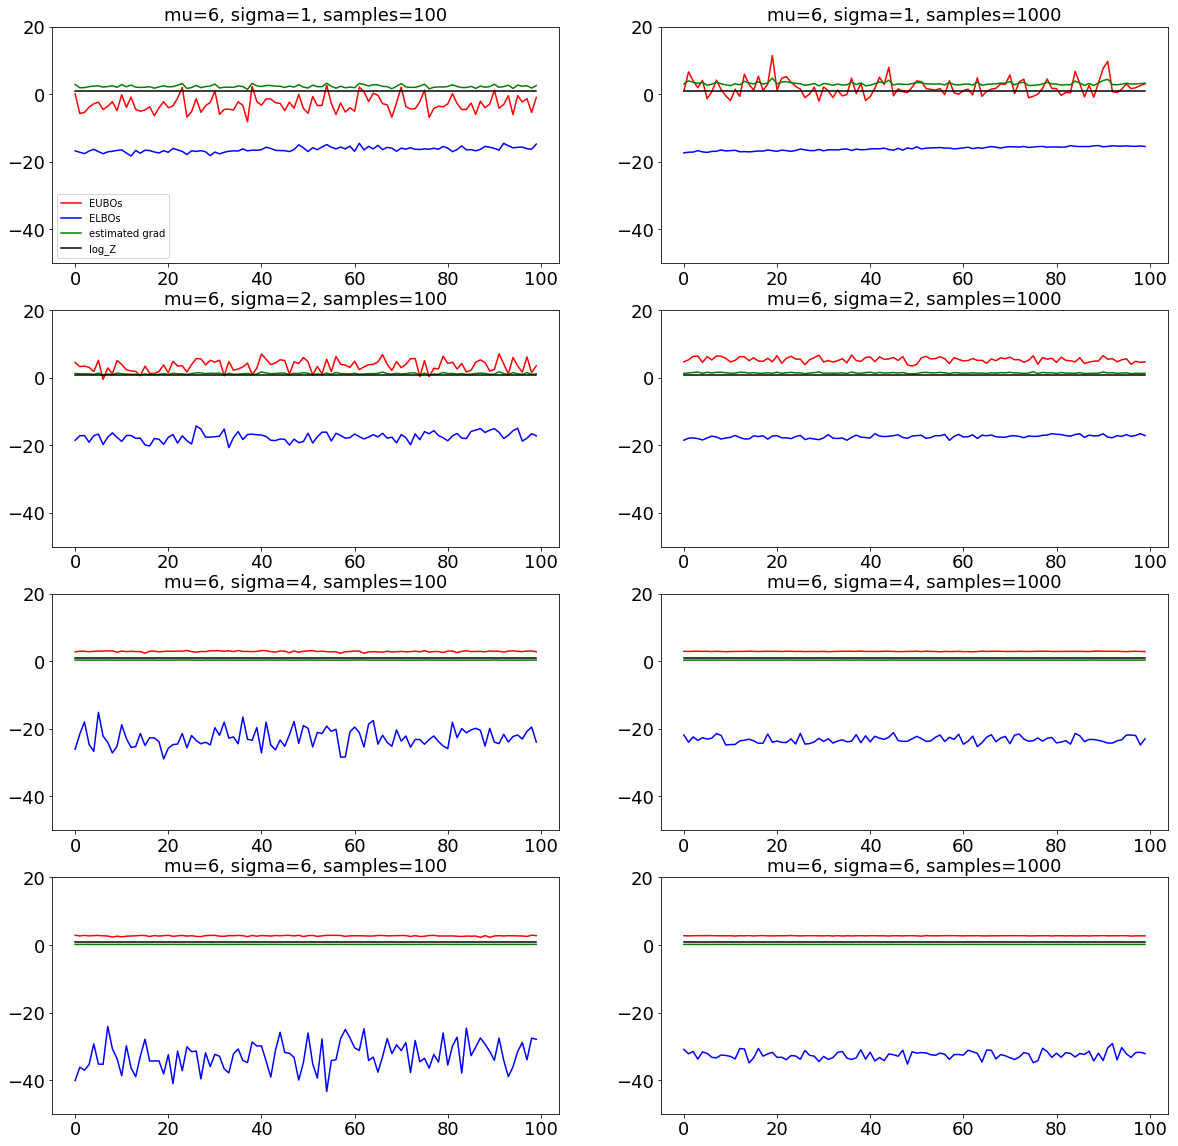

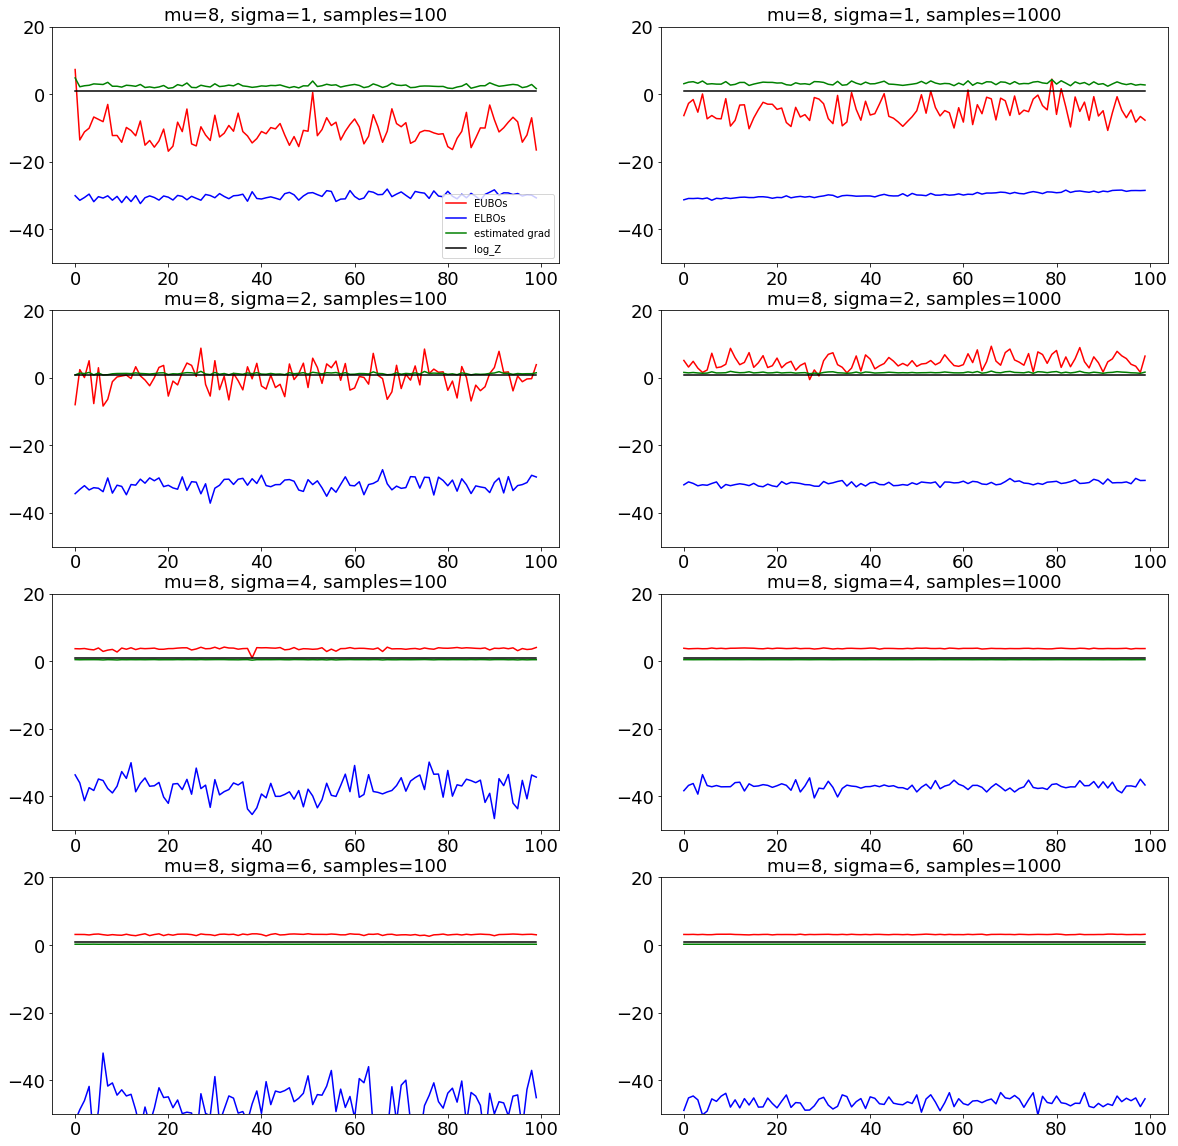

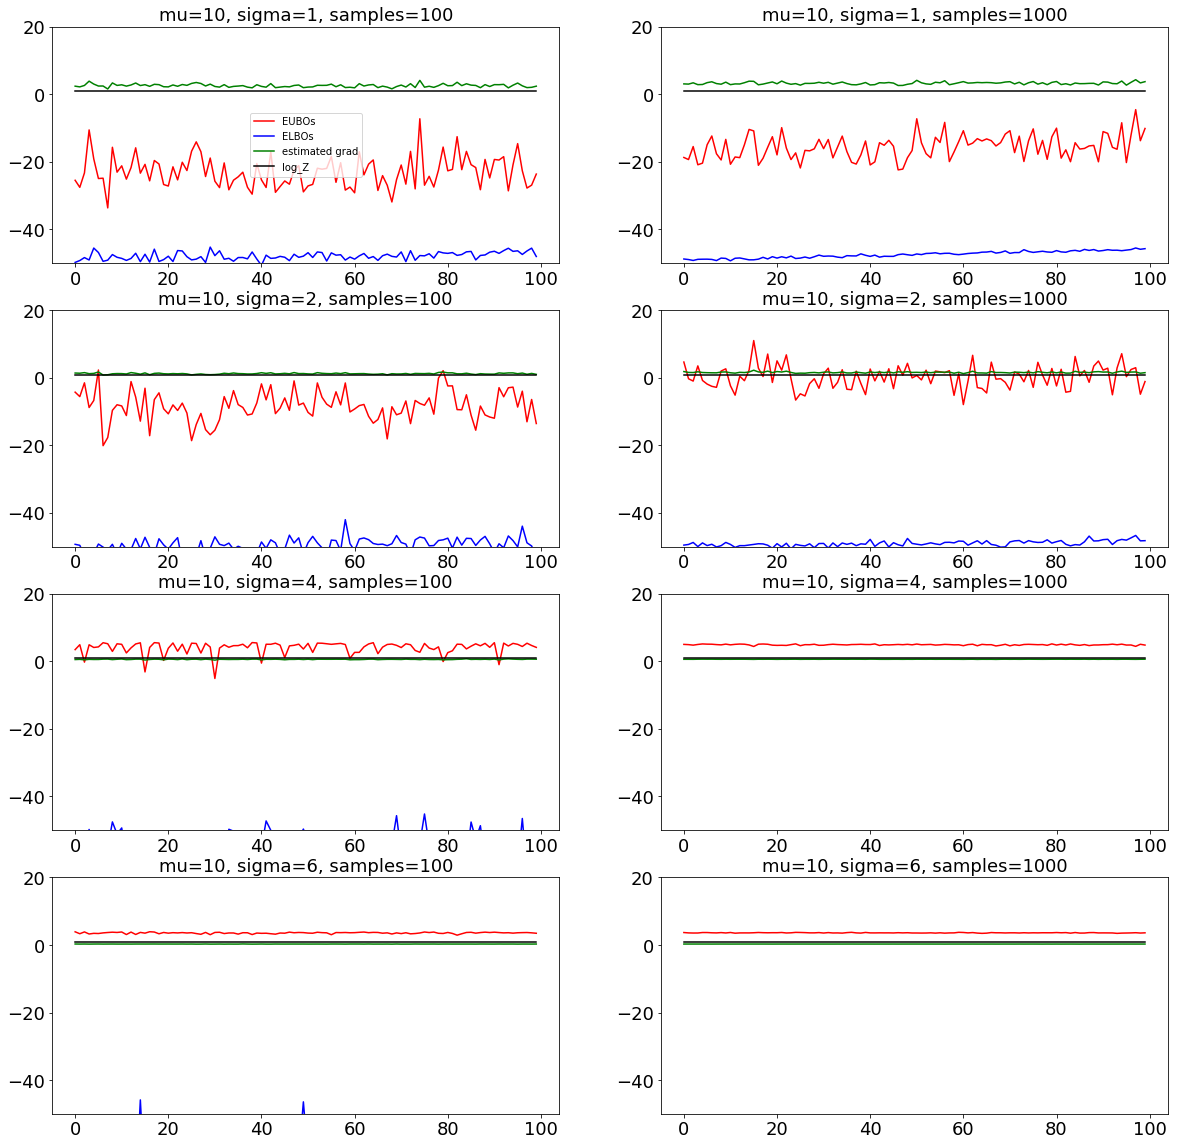

In [43]:
init_mus = np.array([6, 8, 10])
init_sigmas = np.array([1.0, 2.0, 4.0, 6.0])
SAMPLES = np.array([100, 1000])
num_mus = init_mus.shape[0]
num_sigmas = init_sigmas.shape[0]
num_samples = SAMPLES.shape[0]



EUBOs = []
ELBOs = []
Grads = []

for i in range(num_mus):
    EUBOs, ELBOs, Grads, AdamGrads = train(num_sigmas, num_samples, init_mus[i], init_sigmas, SAMPLES, lr)
    plot_results(EUBOs, ELBOs, Grads, AdamGrads, num_sigmas, num_samples, init_mus[i], init_sigmas, SAMPLES)

In [ ]:
fig = plt.figure(figsize=(8,8))
# plt.plot(ELBOs)
ax = fig.add_subplot(111)
ax.plot(EUBOs, 'r', label='EUBOs')
ax.plot(ELBOs, 'b', label='ELBOs')
ax.plot(np.ones(iterations) * log_Z, 'k', label='log_Z')
ax.legend()
plt.savefig('rws-univariate-samples=%d-prior=2.png' % num_samples)

In [ ]:
log_Z